In [1]:
import os

# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax

# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

import sys

# Add custom path
sys.path.append("/pchem-data/meuwly/boittier/home/pycharmm_test/physnetjax")

import e3x
import jax
import numpy as np
import optax
import orbax

from physnetjax.data.data import prepare_datasets
from physnetjax.training.loss import dipole_calc
from physnetjax.models.model import EF
from physnetjax.training.training import train_model  # from model import dipole_calc
from physnetjax.data.batches import _prepare_batches as prepare_batches#prepare_batches, prepare_datasets

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)

from pathlib import Path

[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


2025-02-10 19:19:55.192873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739211595.215306  137643 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739211595.222312  137643 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# files = list(Path("/pchem-data/meuwly/boittier/home/pycharmm_test/data/basepairs").glob("*.npz"))
NATOMS = 10
files = [
    Path("/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz"),

]


20999 * .8

16799.2

In [3]:
train_data, valid_data = prepare_datasets(
    data_key,
    16800,
     4199,
    files,
    clip_esp=False,
    natoms=NATOMS,
    clean=False,
    subtract_atom_energies=False,
    verbose=True,
)

ntest = len(valid_data["E"]) // 2
test_data = {k: v[ntest:] for k, v in valid_data.items()}
valid_data = {k: v[:ntest] for k, v in valid_data.items()}



                                   dcm_dimers_MP2_20999.npz                                    
┏━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ N        ┃ E        ┃ Q        ┃ D          ┃ Z           ┃ R              ┃ F              ┃
┡━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ (20999,) │ (20999,) │ (20999,) │ (20999, 3) │ (20999, 10) │ (20999, 10, 3) │ (20999, 10, 3) │
└──────────┴──────────┴──────────┴────────────┴─────────────┴────────────────┴────────────────┘

dataR (20999, 10, 3)
dataE [-16.64463665 -16.84494252 -16.68936279 -16.69383745 -16.74775377
 -16.79686463 -16.70671807 -16.6819525  -16.70375592 -16.71621446]
dataE [-16.64463665 -16.84494252 -16.68936279 -16.69383745 -16.74775377
 -16.79686463 -16.70671807 -16.6819525  -16.70375592 -16.71621446]
D (20999, 3)
Q 1 (20999,) 20999
Q (20999,)


In [4]:
DEFAULT_DATA_KEYS = ["Z", "R", "D", "E", "F", "N"]
batch_size = 10

test_batches = prepare_batches(data_key, test_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=DEFAULT_DATA_KEYS)

train_batches = prepare_batches(data_key, train_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=DEFAULT_DATA_KEYS)

valid_batches = prepare_batches(data_key, valid_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=DEFAULT_DATA_KEYS)

In [ ]:
# test_batches[0]

In [6]:
model = EF(
    # attributes
    features=128,
    max_degree=0,
    num_iterations=5,
    num_basis_functions=64,
    cutoff=10.0,
    max_atomic_number=18,
    charges=True,
    natoms=NATOMS,
    total_charge=0,
    n_res=3,
    zbl=False,
    debug=False,
)

In [ ]:
# restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-a31d3007-5046-4ae0-a16d-8e45aa2eafb1"
# restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-af722a47-a3a3-4f31-987f-c6a9ab2fb555"
# restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d8bc5d79-f65e-451e-8169-bf6da5170b54"
restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1"
params = train_model(
    train_key,
    model,
    train_data,
    valid_data,
    num_epochs=int(1e6),
    learning_rate=0.0001,
    energy_weight=80,
    dipole_weight=1,
    charges_weight=1,
    forces_weight=1,
    schedule_fn="constant",
    optimizer="amsgrad",
    batch_size=batch_size,
    num_atoms=NATOMS,
    data_keys=DEFAULT_DATA_KEYS,
    restart=restart,
    name="dichloromethane",
    print_freq=1,
    objective="valid_loss",
    best=1e6,
    batch_method="default",
)

                                            Train Data                                             
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ R              ┃ Z           ┃ F              ┃ E          ┃ N          ┃ D          ┃ Q        ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━┩
│ (16800, 10, 3) │ (16800, 10) │ (16800, 10, 3) │ (16800, 1) │ (16800, 1) │ (16800, 3) │ (16800,) │
└────────────────┴─────────────┴────────────────┴────────────┴────────────┴────────────┴──────────┘

                                      Validation Data                                       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓
┃ R             ┃ Z          ┃ F             ┃ E         ┃ N         ┃ D         ┃ Q       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩
│ (2099, 10, 3) │ (2099, 10) │ (2099, 10, 3) │ (2099, 1) │ (2099, 1) │ (2099, 3) │ (2099,) │
└───────────────┴────────────┴───────────────┴───────────┴───────────┴───────────┴─────────┘

Using default (fat) batching method


Training Routine

.,,uod8B8bou,,.
              ..,uod8BBBBBBBBBBBBBBBBRPFT?l!i:.
         ,=m8BBBBBBBBBBBBBBBRPFT?!||||||||||||||
         !...:!TVBBBRPFT||||||||||!!^^""'   ||||
         !.......:!?|||||!!^^""'            ||||
         !.........||||                     ||||
         !.........||||  ##                 ||||
         !.........||||      PhysNet        ||||
         !.........||||      JAX            ||||
         !.........||||                     ||||
         !.........||||                     ||||
         `.........||||                    ,||||
          .;.......||||               _.-!!|||||
   .,uodWBBBBb.....||||       _.-!!|||||||||!:'
!YBBBBBBBBBBBBBBb..!|||:..-!!|||||||!iof68BBBBBb....
!..YBBBBBBBBBBBBBBb!!||||||||!iof68BBBBBBRPFT?!::   `.
!....YBBBBBBBBBBBBBBbaaitf68BBBBBBRPFT?!:::::::::     `.
!......YBBBBBBBBBBBBBBBBBBBRPFT?!::::::;:!^"`;:::       `.
!........YBBBBBBBBBBRPFT?!::::::::::^''...::::::;         iBBbo.
`..........YBRPFT?!::::::::::::::::::::::::;iof68bo.      WBBBBbo.
  `..........:::::::::::::::::::::::;iof688888888888b.     `YBBBP^'
    `........::::::::::::::::;iof688888888888888888888b.     `
      `......:::::::::;iof688888888888888888888888888888b.
        `....:::;iof688888888888888888888888888888888899fT!
          `..::!8888888888888888888888888888888899fT|!^"'
            `' !!988888888888888888888888899fT|!^"'
                `!!8888888888888888899fT|!^"'
                  `!988888888899fT|!^"'
                    `!9899fT|!^"'
                      `!^"'

DATA_PATH: /pchem-data/meuwly/boittier/home/pycharmm_test/data

LOGS_PATH: /pchem-data/meuwly/boittier/home/pycharmm_test/logs

ANALYSIS_PATH: /pchem-data/meuwly/boittier/home/pycharmm_test/analysis

MAIN_PATH: /pchem-data/meuwly/boittier/home/pycharmm_test

PYCHARMM_DIR: None

Start Time:  10:33:51

                                                Optimizer Arguments                                                
┏━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━┳━━━━━━┳━━━━━━━┓
┃ optimizer ┃ optimized_… ┃ schedule_fn ┃ scheduling… ┃ transform ┃ reduce_tra… ┃ clip_glob… ┃ b1  ┃ b2   ┃ eps   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━╇━━━━━━╇━━━━━━━┩
│ amsgrad   │ GradientTr… │ constant    │ <function   │ None      │ GradientTr… │ 10.0       │ 0.9 │ 0.99 │ 0.001 │
│           │ chain.<loc… │             │ constant_s… │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │ at          │           │ at          │            │     │      │       │
│           │ 0x14807aef… │             │ 0x14807aed… │           │ 0x14807aef… │            │     │      │       │
│           │ update=<fu… │             │             │           │ update=<fu… │            │     │      │       │
│           │ chain.<loc… │             │             │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │             │           │ at          │            │     │      │       │
│           │ 0x14807aef… │             │             │           │ 0x14807aef… │            │     │      │       │
└───────────┴─────────────┴─────────────┴─────────────┴───────────┴─────────────┴────────────┴─────┴──────┴───────┘

                                    Training Parameters                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ energy_weight ┃ forces_weight ┃ dipole_weight ┃ charges_weight ┃ batch_size ┃ num_atoms ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 80            │ 1             │ 1             │ 1              │ 10         │ 10        │
└───────────────┴───────────────┴───────────────┴────────────────┴────────────┴───────────┘

                                                  Training Style                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ restart                                               ┃ best      ┃ data_keys                      ┃ objective  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts… │ 1000000.0 │ ('Z', 'R', 'D', 'E', 'F', 'N') │ valid_loss │
└───────────────────────────────────────────────────────┴───────────┴────────────────────────────────┴────────────┘

                                                Validation Batch[0]                                                
┏━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Z      ┃ R        ┃ D       ┃ E       ┃ F        ┃ N     ┃ dst_idx ┃ src_idx ┃ batch_ma… ┃ batch_se… ┃ atom_ma… ┃
┡━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ (100,) │ (100, 3) │ (10, 3) │ (10, 1) │ (100, 3) │ (10,) │ (900,)  │ (900,)  │ (900,)    │ (100,)    │ (100,)   │
└────────┴──────────┴─────────┴─────────┴──────────┴───────┴─────────┴─────────┴───────────┴───────────┴──────────┘

Extra Validation Info:
Z: Array[2099, 10] i32 n=20990 (82Kb) x∈[0, 17] μ=7.984 σ=7.304 cpu:0
R: Array[2099, 10, 3] n=62970 (0.2Mb) x∈[-17.787, 17.716] μ=0.017 σ=8.742 cpu:0
E: Array[2099, 1] 8.2Kb x∈[-33.761, -16.534] μ=-31.804 σ=5.001 cpu:0
N: Array[2099, 1] i32 8.2Kb x∈[5, 10] μ=9.505 σ=1.494 cpu:0
F: Array[2099, 10, 3] n=62970 (0.2Mb) x∈[-4.306, 4.273] μ=3.711e-10 σ=0.737 cpu:0
D: Array[2099, 3] n=6297 (25Kb) x∈[-0.297, 0.295] μ=-0.002 σ=0.114 cpu:0


/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4073 │ 4073  │ Array gpu:0 0.006 │ 2025-02-11 10:48:39.036109 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

Restoring from /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1/epoch-4073
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
Training resumed from step 4073, best_loss Array gpu:0 0.006


                                                                       Model Attributes                                                                        
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ features ┃ max_degree ┃ num_iterations ┃ num_basis_functions ┃ cutoff ┃ max_atomic_number ┃ charges ┃ natoms ┃ total_charge ┃ n_res ┃ zbl   ┃ debug ┃ efa   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 128      │ 0          │ 5              │ 64                  │ 10.0   │ 18                │ True    │ 10     │ 0            │ 3     │ False │ False │ False │
└──────────┴────────────┴────────────────┴─────────────────────┴────────┴───────────────────┴─────────┴────────┴──────────────┴───────┴───────┴───────┴───────┘

...

Output()

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

...

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4073 │ 4073  │ Array gpu:0 0.006 │ 2025-02-11 10:48:39.036109 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 10.0
    max_atomic_number = 18
    charges = True
    natoms = 10
    total_charge = 0
    n_res = 3
    zbl = False
    debug = False
    efa = False
)


210it [06:13,  1.78s/it]


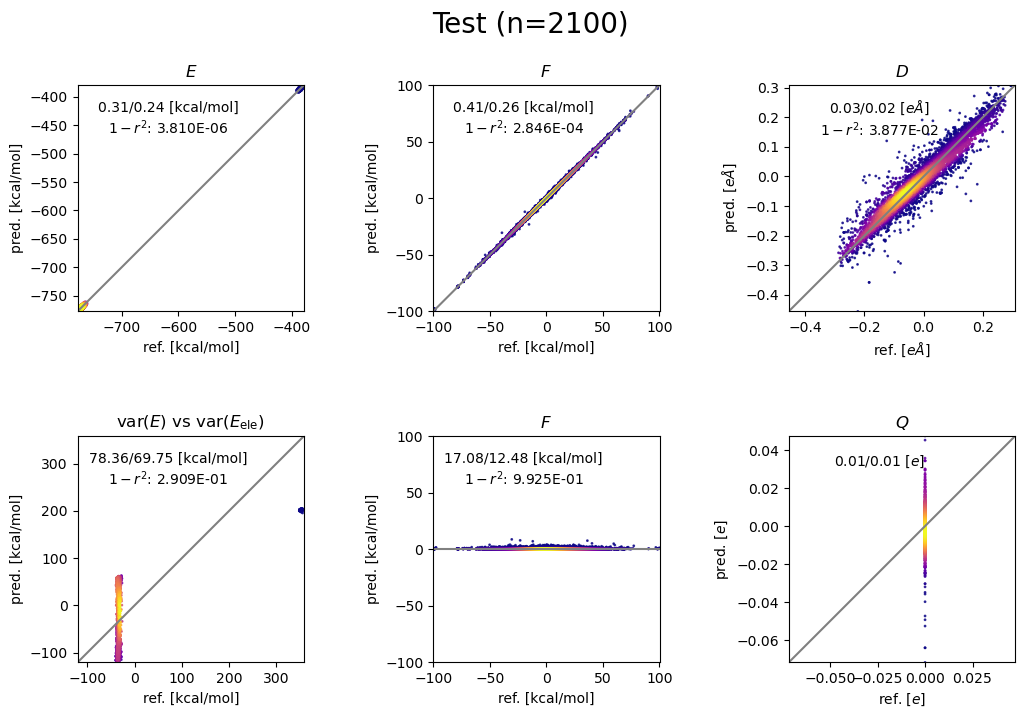

In [33]:
from physnetjax.restart.restart import get_last, get_files, get_params_model
from physnetjax.analysis.analysis import plot_stats
# restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-af722a47-a3a3-4f31-987f-c6a9ab2fb555"
restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d8bc5d79-f65e-451e-8169-bf6da5170b54"
restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1"

restart = get_last(restart)

params, model = get_params_model(restart)
model.natoms = 10
print(model)

output = plot_stats(test_batches, model, params, _set="Test", 
               do_kde=True, batch_size=batch_size)

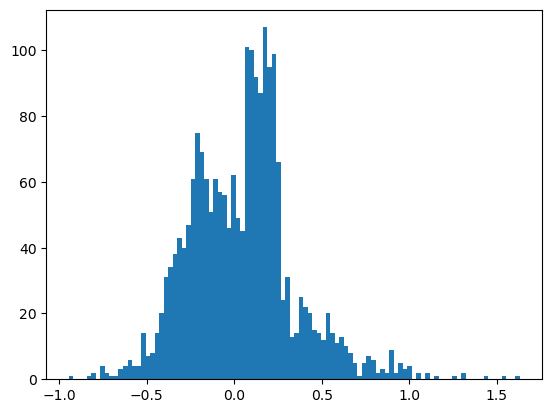

In [34]:
import matplotlib.pyplot as plt
_ = plt.hist(output["Es"] - output["predEs"], bins=100)

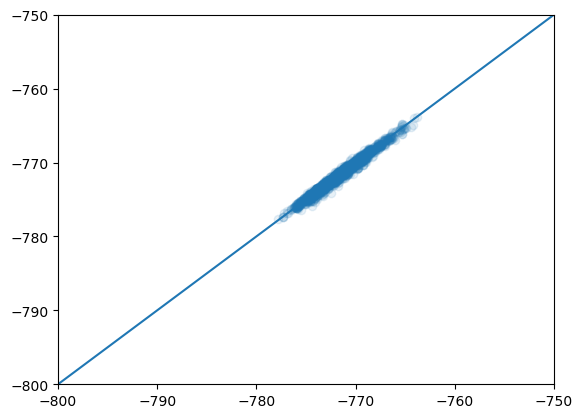

In [35]:
plt.scatter(output["Es"] , output["predEs"], alpha=0.1)
plt.xlim(-800, -750)
plt.ylim(-800, -750)
plt.plot([-800, -750], [-800, -750])

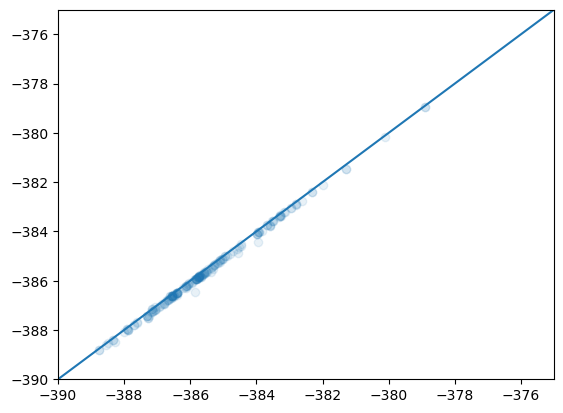

In [36]:
plt.scatter(output["Es"] , output["predEs"], alpha=0.1)
plt.xlim(-390, -375)
plt.ylim(-390, -375)
plt.plot([-390, -375], [-390, -375])

In [27]:
output.keys()

dict_keys(['Es', 'Eeles', 'predEs', 'Fs', 'predFs', 'Ds', 'predDs', 'charges', 'outputs', 'batches', 'E_rmse', 'E_mae', 'F_rmse', 'F_mae', 'D_rmse', 'D_mae', 'n_params', 'features', 'max_degree', 'num_iterations', 'num_basis_functions', 'cutoff', 'max_atomic_number', 'natoms', 'total_charge', 'n_res', 'zbl', 'debug', 'efa'])

In [33]:
output["Ds"][0], output["Ds"][1] #.shape #.shape

(array([[-0.08294858,  0.00452198,  0.07729173],
        [-0.05049316,  0.03344288, -0.26984567],
        [-0.16725687,  0.04534139,  0.04329089],
        [ 0.10398953,  0.00146152,  0.07337726],
        [-0.0180975 ,  0.08456521, -0.03406788],
        [ 0.04269129,  0.13071585,  0.21775129],
        [-0.07087872,  0.19837048,  0.12712117],
        [ 0.12802869, -0.01329321,  0.05040489],
        [-0.11746533,  0.09030263,  0.03117939],
        [-0.13118346, -0.11634753,  0.13742762]]),
 array([[-0.16867593, -0.1459028 ,  0.15132147],
        [ 0.06824402,  0.08248993,  0.00747043],
        [-0.08785364, -0.02316474,  0.18931985],
        [-0.13364619,  0.0564748 , -0.03377433],
        [ 0.20526442,  0.06456273, -0.05318866],
        [-0.02481614,  0.11241328, -0.08338308],
        [-0.00161538, -0.16277966,  0.03515507],
        [-0.04832919,  0.05645647,  0.03736651],
        [ 0.10276389,  0.14107061, -0.13242117],
        [ 0.1684186 , -0.16965777, -0.07584561]]))

In [30]:
output["predDs"].shape

(210, 10, 3)

In [32]:
train_data

{'R': array([[[  1.514,  10.433,  -0.726],
         [  1.338,  11.156,   0.109],
         [  2.345,  10.905,  -1.477],
         ...,
         [-11.436,   7.188,  -6.076],
         [-13.517,   8.471,  -5.693],
         [-10.816,   8.816,  -4.477]],
 
        [[-13.269,  -7.447,  15.093],
         [-12.974,  -7.983,  14.152],
         [-13.074,  -8.003,  16.039],
         ...,
         [ -0.902,  -5.608,   7.046],
         [ -1.267,  -3.27 ,   6.682],
         [ -2.716,  -5.147,   8.443]],
 
        [[  9.069,   6.65 ,   4.575],
         [  9.711,   7.208,   5.215],
         [  8.695,   7.281,   3.767],
         ...,
         [  2.733,   3.069,   7.411],
         [  5.083,   2.84 ,   7.76 ],
         [  3.817,   3.977,   5.454]],
 
        ...,
 
        [[-11.07 ,   8.627,   0.778],
         [-10.158,   8.257,   1.332],
         [-11.352,   9.571,   1.193],
         ...,
         [  0.   ,   0.   ,   0.   ],
         [  0.   ,   0.   ,   0.   ],
         [  0.   ,   0.   ,   0.   ]],
 
